# **Progetto:** de-noiser automatico basato su campionamento e profilazione del rumore

### **Autore:** Francesco Spezia
### **Collaboratori:** Roberto Lazzarini

## **Obiettivo:** 
#### Creare un tool in grado di ridurre vari tipi di rumore da un file audio, basandosi su un'analisi di una porzione di rumore, effettuando una divisione in varie bande di frequenze, calcolando l'ampiezza media del volume di ogni banda, allo scopo di creare un profilo del rumore.
#### Il profilo ottenuto verrà poi utilizzato come filtro, da sommare al file audio completo, in modo da ridurre il rumore in punti specifici sull'intero spettro delle frequenze, senza intaccare troppo il segnale da ripulire.

##### Il programma è ispirato da strumenti avanzati di riduzione del rumore (come "Edison", riportato per esempio qui sotto), dove viene analizzato inizialmente il rumore per crearne un profilo, per poi applicarlo alla parte di segnale da ripulire, selezionando alcuni parametri di sensibilità dei filtri da applicare.

<video controls src="src/Edison_example.mkv" type="video/mkv" width="500" height="340" />

# **Struttura del codice:**

<style>
    a {color: white;}
    h3 {font-weight: bold}
</style>

<h3>1. <a href="#section_1"> Input </a></h3>
<h4>&emsp; 1.1<a href="#section_1_1"> Isolamento del rumore </a></h4>

<h3>2. <a href="#section_2"> Setup del rumore </a></h3>
<h4>&emsp; 2.1<a href="#section_2_1"> Creo l'oggetto "Band" </a></h4>
<h4>&emsp; 2.2<a href="#section_2_2"> Funzioni di utility </a></h4>

<h3>3. <a href="#section_3"> Profilazione </a></h3>

<h3>4. <a href="#section_4"> Applicazione del filtro </a></h3>
<h4>&emsp; 4.1 <a href="#section_4_1"> Funzione di filtraggio </a></h4>
<h4>&emsp; 4.2 <a href="#section_4_2"> Eseguo la funzione </a></h4>

<h3>5. <a href="#section_5"> Output </a></h3>

<h3>6. <a href="#section_6"> Considerazioni finali </a></h3>

<h4><a href="#section_7"><b>7. Bonus:</b> approcci utilizzati ed analisi dei fallimenti </a></h4>

### Librerie utilizzate

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import signal
import IPython
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from pydub import AudioSegment
import pyaudio
import math
np.set_printoptions(suppress=True) # don't use scientific notation

### **Variabili Globali**

In [202]:
sr = 44100          # sampling rate
band_N = 150        # number of bands in noise profile

wavname = "Noise/05_drums_with_square_noise.wav"   # load your noisy file here

start_point = 0     # ms, where to start isolating the noise in the file
cut_point = 5000    # ms, where to cut the isolated noise

### Funzione di utility: plotFile
input: asse x, asse y, etichetta del plot, nome asse x, nome asse y

In [203]:
def plotFile(x, y, title, xLabel, yLabel):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, '-r', label="%s" % title)
    plt.xlabel("%s" % xLabel)
    plt.ylabel("%s" % yLabel)
    plt.legend()
    plt.tight_layout()
    plt.grid()

<h3 id="section_1"><b>1. Input:</b> campionamento della registrazione originale</h3>

In [204]:
f_s, recording = wav.read(wavname)  # load as sample rate and signal
N = len(recording)                  # recording's length
t = 1/f_s * np.arange(N)            # recording's duration

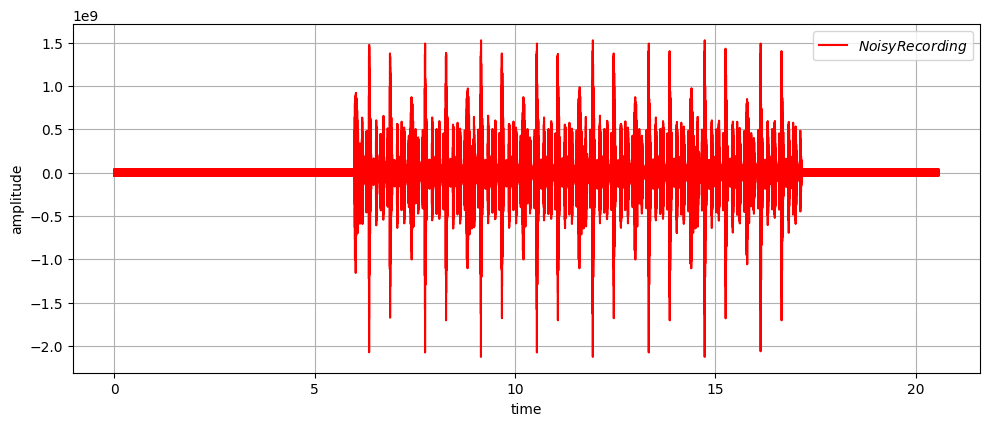

In [205]:
plotFile(t, recording, "$Noisy Recording$", "time", "amplitude")
plt.show()

IPython.display.Audio(recording, rate=sr)

<h4 id="section_1_1"><b>1.1 Input:</b> isolo la parte del file audio originale con solo rumore</h4>

In [206]:
wavname_noise_sample = "noise_sample.wav"       # create noise file

cut = AudioSegment.from_file(wavname, "wav")
cut = cut[start_point:cut_point]
cut.export(wavname_noise_sample, format="wav")  # export the isolated noise

# load the isolated noise as sample rate and signal
f_s_noise, noise_sample = wav.read(wavname_noise_sample)

##### Elaborazione del rumore isolato

In [207]:
N_noise = len(noise_sample)                     # isolated noise length
t_noise = 1/f_s_noise * np.arange(N_noise)      # isolated noise duration
f = f_s_noise/N_noise * np.arange(N_noise)      # isolated noise frequency

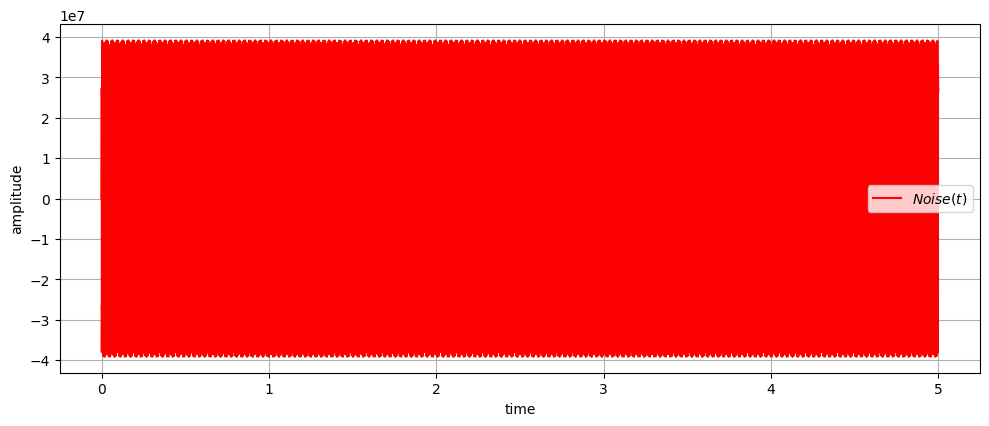

In [208]:
plotFile(t_noise, noise_sample, "$Noise(t)$", "time", "amplitude")
# plt.xlim(0,0.1)     # uncomment to zoom on the noise waveshape
plt.show

IPython.display.Audio(noise_sample, rate=sr)

<h3 id="section_2"><b>2. Setup del rumore:</b> trasformo in fourier il rumore isolato
</h3>

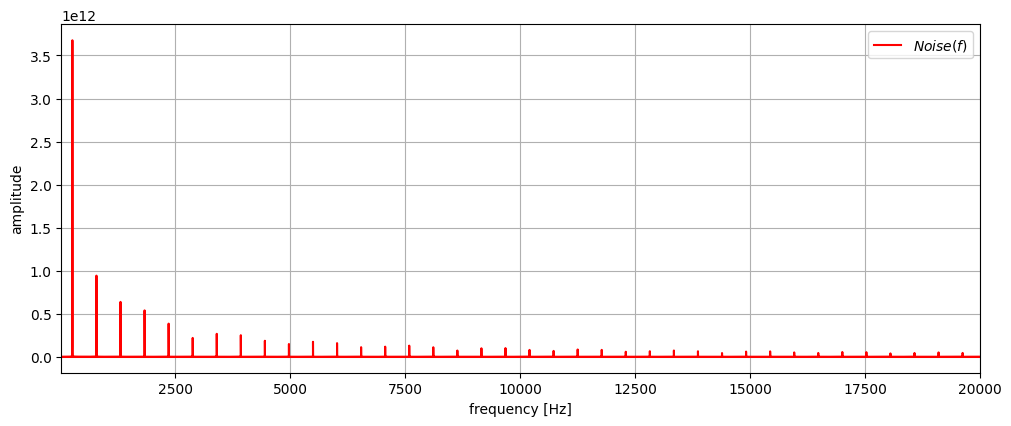

In [209]:
Fourier_noise = np.fft.fft(noise_sample)
freq_noise = np.fft.fftfreq(N_noise, 1/f_s_noise)

N_2_noise = math.ceil(N_noise/2)    # divide noise length to use in further operations

plotFile(freq_noise, np.abs(Fourier_noise), "$Noise(f)$", "frequency [Hz]", "amplitude")
plt.xlim([20,20000])                # plot only frequencies between 20Hz and 20kHz (we will operate only on the audible spectrum) 
plt.show()

<h4 id="section_2_1"><b>2.1 Setup del rumore:</b> creo l'oggetto "Band" </h4>
&emsp;&emsp; L'oggetto sarà utilizzato per contenere le informazioni di ogni banda in cui verrà suddiviso il sample del rumore

In [210]:
class Band (object):
    def __init__(self, low_treshold, high_treshold, avg_amp):
        self.low_treshold = low_treshold
        self.high_treshold = high_treshold
        self.avg_amp = avg_amp
    
    def printBand(self):
        return("Band: [%dHz - %dHz]\t Volume: %d\n" % (self.low_treshold, self.high_treshold, self.avg_amp))

<h4 id="section_2_2"><b>2.2 Setup del rumore:</b> funzioni di utility </h4>

In [211]:
# return the list position of a given frequency
def bandCut (N_frames, freqList, frequency):
    for i in range (N_frames):
        if math.floor(freqList[i]) == frequency:
            return i
    
    print("bandCut error")
    return False

In [212]:
# print every band of the noise profile
def printBands (noiseProfile):
    profile_out = open("Output/printBands.txt", "w")
    
    for Band in noiseProfile:
        profile_out.write(Band.printBand())
    
    profile_out.close()

In [213]:
# plot the full noise profile
def plotProfile (noiseProfile):
    x = []
    y = []

    for i in range (len(noiseProfile)-1):
        x.append(noiseProfile[i].high_treshold)
        y.append(noiseProfile[i].avg_amp)

    x[0] = noiseProfile[0].low_treshold

    plotFile(x, y, "$Noise Profile$", "frequency [Hz]", "amplitude")
    plt.xlim([20,22000])
    plt.show()

In [214]:
# filter all the frequencies beside the audible spectrum [20Hz, 20kHz]
def simpleFilter (unfiltered, frequencies):
    low_index = np.argwhere(np.abs(frequencies) <= 20)
    high_index = np.argwhere(np.abs(frequencies) >= 20000)

    unfiltered[low_index] = 0
    unfiltered[high_index] = 0

    return unfiltered

<h3 id="section_3"><b>3. Profilazione:</b> creo il profilo del rumore</h3>

In [215]:
Fourier_noise = simpleFilter(Fourier_noise, freq_noise) # initial 20-20k filtering

noise_profile = []          # our noise profile will be a list of Band objects

band_size = math.floor(N_2_noise/band_N)            # Band width


low_cut = bandCut(N_2_noise, freq_noise, 20)        # get starting and end position
high_cut = bandCut(N_2_noise, freq_noise, 20000)    #   at 20 and 20k Hz

i = low_cut                                         # i will be our iterator

In [216]:
# populate the bands list

while i < high_cut-1:    
    band_min = freq_noise[i]    # band minimum frequency
    
    j = i+band_size             # band width offset

    # offset for the last band
    if (j >= high_cut-1):
        j = high_cut-2
    
    band_max = freq_noise[j]    # band maximum frequency
    band_avg = Fourier_noise[i] # band average amplitude

    divider = 1
    for k  in range(i+1,j):
        if (Fourier_noise[k]>0):
            band_avg += Fourier_noise[k]
            divider += 1

    # calculate band average amplitude
    # band_avg = band_avg/divider

    if band_avg < 0:
        band_avg = 0
    
    # append band with collected parameters to noise profile
    noise_profile.append(Band(band_min, band_max, band_avg))

    # increment iterator
    i = j+1                    # go to next frequency in list

Stampa del contenuto di ogni banda del profilo del rumore ottenuto presente in _'Output/printBands.txt'_

Noise profile length: 136 bands


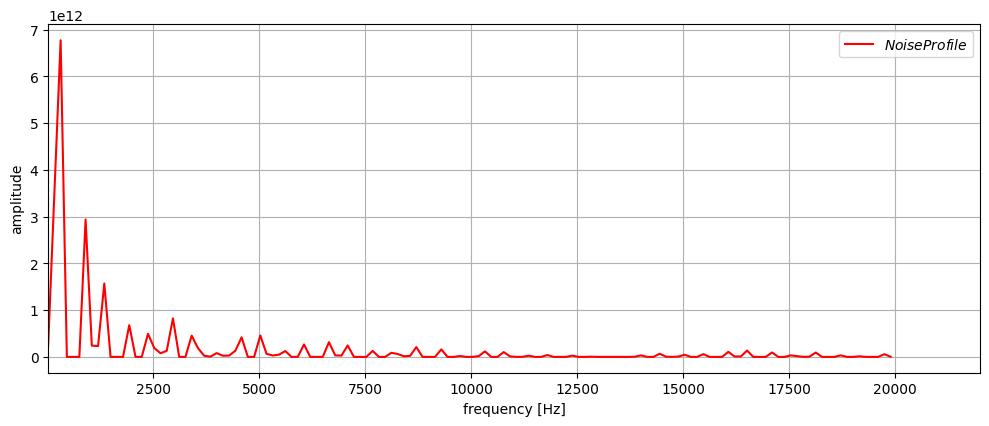

In [217]:
print("Noise profile length: %s bands" % len(noise_profile))

printBands(noise_profile)

plotProfile(noise_profile)


<h3 id="section_4"><b>4. Applicazione del filtro:</b> analizzo il file completo in fourier</h3>

In [218]:
# make FastFourierTransorm of the noise sample, and get its frequencies
Fourier_rec = np.fft.fft(recording)
freq_rec = np.fft.fftfreq(N, 1/f_s)

N_2_rec = math.ceil(N/2)    # half of rec's length

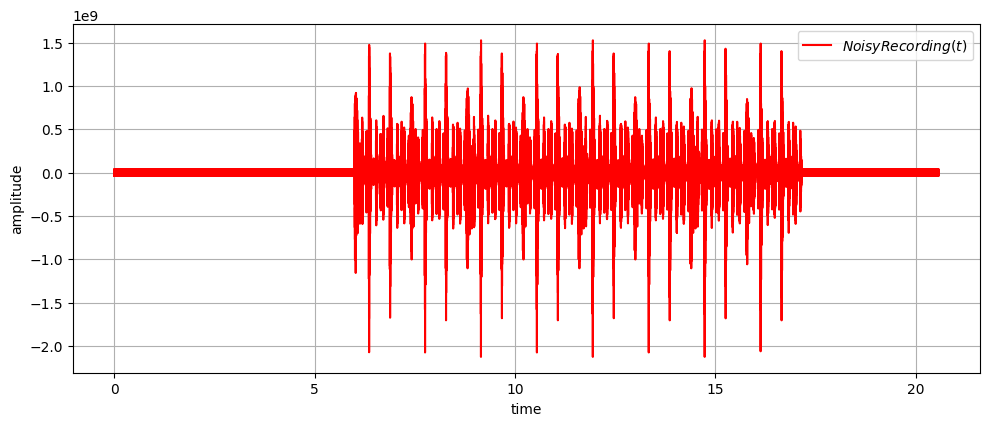

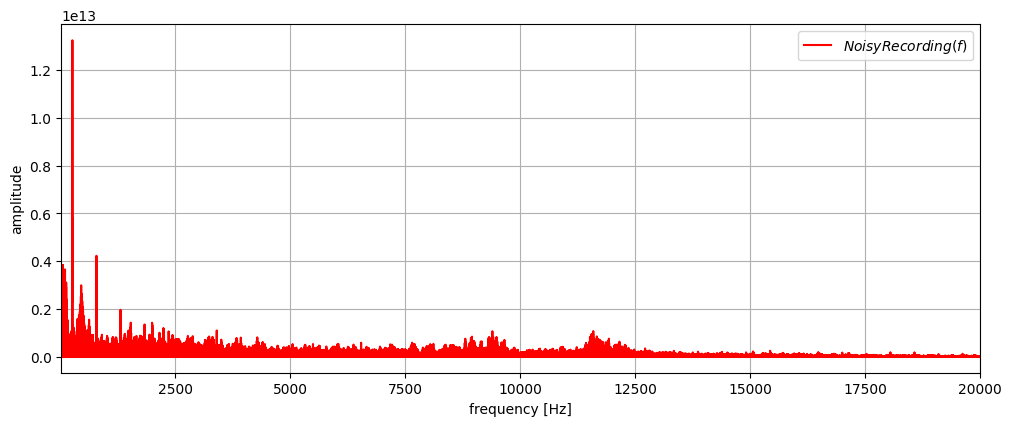

In [219]:
plotFile(t, recording, "$Noisy Recording(t)$", "time", "amplitude")
plt.show()
plotFile(freq_rec, np.abs(Fourier_rec), "$Noisy Recording(f)$", "frequency [Hz]", "amplitude")
plt.xlim([20,20000])
plt.show()

<h4 id="section_4_1"><b>4.1 Applicazione del filtro:</b> funzione di filtraggio in FFT banda per banda</h4>

In [220]:
def filterBands (filter, unfiltered, frequencies):
    manipulated = 0     # counter of number of frequency points affected by filter

    for band in filter:
        # list of indexes of band in frequencies
        index = np.argwhere((np.abs(frequencies)>=band.low_treshold)*(np.abs(frequencies)<band.high_treshold))
        index = np.squeeze(index)

        for i in index:
            if (band.avg_amp>0) & (unfiltered[i]>0):
                check = unfiltered[i]
                unfiltered[i] -= (band.avg_amp)

                if (check!=unfiltered[i]): manipulated += 1

    print("Number of frequencies filtered: ", manipulated)
    return unfiltered

<h4 id="section_4_2"><b>4.2 Applicazione del filtro:</b> eseguo la funzione filterBands sulla registrazione completa</h4>

Number of frequencies filtered:  235958


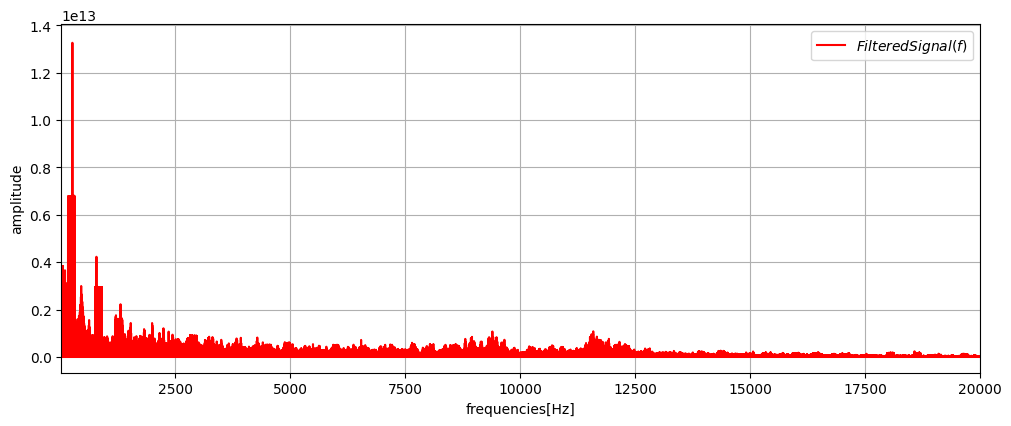

In [221]:
filtered_by_bands = filterBands(noise_profile, Fourier_rec, freq_rec)
filtered = simpleFilter(filtered_by_bands, freq_rec)    # filter out frequencies <20Hz and >20kHz

# length check
if len(Fourier_rec)!=len(filtered): print("Filtering error")

plotFile(freq_rec, np.abs(filtered), "$Filtered Signal(f)$", "frequencies[Hz]", "amplitude")
plt.xlim([20,2e4])
plt.show()

<h3 id="section_5"><b>5. Output:</b> trasformata inversa del file filtrato</h3>

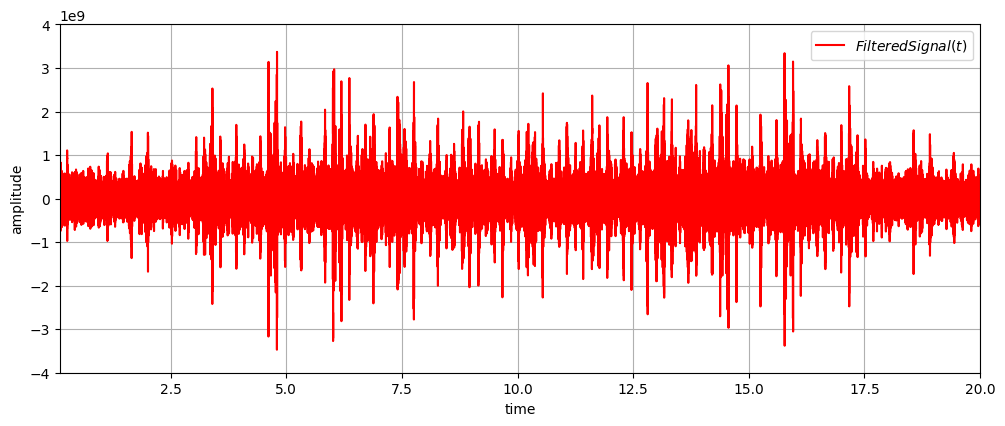

In [222]:
filtered_recording = np.fft.ifft(filtered)
plotFile(t, filtered_recording, "$Filtered Signal(t)$", "time", "amplitude")
plt.xlim([0.1,20])
plt.ylim([-4e9,4e9])
plt.show()

IPython.display.Audio(filtered_recording, rate=sr)

<h3 id="section_5"><b>6. Considerazioni finali:</b></h3>

<h3 id="section_7"><b>7. Bonus:</b> approcci utilizzati ed analisi dei fallimenti</h3>